<a href="https://colab.research.google.com/github/Manavkakadiya/ManavKakadiya-demo/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from skimage.feature import local_binary_pattern, hog
from PIL import Image
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("All libraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All libraries imported successfully!


In [81]:
JAFFE_TRAIN_PATH = '/content/drive/MyDrive/CO3519_FER/JAFFE-[70,30]/JAFFE-[70,30]/train'
JAFFE_TEST_PATH = '/content/drive/MyDrive/CO3519_FER/JAFFE-[70,30]/JAFFE-[70,30]/test'
CK_TRAIN_PATH = '/content/drive/MyDrive/CO3519_FER/CK_dataset/CK_dataset/train'
CK_TEST_PATH = '/content/drive/MyDrive/CO3519_FER/CK_dataset/CK_dataset/test'

# Standardized labels (lowercase) - target format
STANDARD_EMOTION_LABELS = ['anger', 'fear', 'happy', 'neutral', 'sadness', 'surprise']

# Image processing parameters
IMG_SIZE = (64, 64)

# Feature extraction parameters
LBP_RADIUS = 1
LBP_N_POINTS = 8 * LBP_RADIUS

HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

print(f"Configuration complete!")
print(f"Standard emotion labels: {STANDARD_EMOTION_LABELS}")
print(f"Image size: {IMG_SIZE}")

Configuration complete!
Standard emotion labels: ['anger', 'fear', 'happy', 'neutral', 'sadness', 'surprise']
Image size: (64, 64)


In [82]:
def detect_emotion_folders(data_path):
    """
    Automatically detect which emotion folders exist in the given path.
    Returns a dictionary mapping standardized names to actual folder names.
    """
    if not os.path.exists(data_path):
        print(f"ERROR: Path does not exist: {data_path}")
        return {}

    # Get all subdirectories
    actual_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

    print(f"\nDetected folders in {data_path}:")
    print(f"  {actual_folders}")

    # Create mapping from standardized names to actual folder names
    emotion_mapping = {}

    # Possible variations for each emotion
    emotion_variations = {
        'anger': ['anger', 'Anger', 'angry', 'Angry', 'AN'],
        'fear': ['fear', 'Fear', 'FE'],
        'happy': ['happy', 'Happy', 'HA'],
        'neutral': ['neutral', 'Neutral', 'NE'],
        'sadness': ['sadness', 'Sadness', 'sad', 'Sad', 'SA'],
        'surprise': ['surprise', 'Surprise', 'SU']
    }

    for standard_name, variations in emotion_variations.items():
        for variation in variations:
            if variation in actual_folders:
                emotion_mapping[standard_name] = variation
                break

    print(f"\nEmotion mapping created:")
    for standard, actual in emotion_mapping.items():
        print(f"  {standard} -> {actual}")

    return emotion_mapping

In [83]:
def load_and_detect_faces(data_path, emotion_mapping):
    """
    Load images from directory structure and detect faces using Haar Cascade.

    Args:
        data_path: Path to the dataset directory containing emotion folders
        emotion_mapping: Dictionary mapping standardized names to actual folder names

    Returns:
        images: Numpy array of detected and cropped face images
        labels: List of corresponding emotion labels (standardized to lowercase)
    """
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    images = []
    labels = []

    for standard_emotion, actual_folder in emotion_mapping.items():
        emotion_path = os.path.join(data_path, actual_folder)

        if not os.path.exists(emotion_path):
            print(f"Warning: Path not found: {emotion_path}")
            continue

        print(f"Loading {standard_emotion} (from {actual_folder}) images...")

        image_count = 0
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)

            # Skip if not an image file
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
                continue

            # Read image
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect faces
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # If face detected, crop and resize
            if len(faces) > 0:
                (x, y, w, h) = faces[0]  # Take first detected face
                face_roi = gray[y:y+h, x:x+w]
                face_resized = cv2.resize(face_roi, IMG_SIZE)
                images.append(face_resized)
                labels.append(standard_emotion)  # Use standardized name
                image_count += 1

        print(f"  Loaded {image_count} images for {standard_emotion}")

    print(f"Total loaded: {len(images)} images")

    # Convert to numpy array
    images = np.array(images)

    return images, labels

def apply_histogram_equalization(images):
    """Apply histogram equalization for contrast enhancement."""
    equalized = np.array([cv2.equalizeHist(img) for img in images])
    return equalized

def augment_data(images, labels):
    """
    Augment training data with horizontal flip and rotations.

    Args:
        images: Numpy array of original images
        labels: List of original labels

    Returns:
        Augmented images (numpy array) and labels (list) - 4x original size
    """
    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        # Original image
        augmented_images.append(img)
        augmented_labels.append(label)

        # Horizontal flip
        flipped = cv2.flip(img, 1)
        augmented_images.append(flipped)
        augmented_labels.append(label)

        # Rotation +10 degrees
        h, w = img.shape
        M = cv2.getRotationMatrix2D((w/2, h/2), 10, 1.0)
        rotated_pos = cv2.warpAffine(img, M, (w, h))
        augmented_images.append(rotated_pos)
        augmented_labels.append(label)

        # Rotation -10 degrees
        M = cv2.getRotationMatrix2D((w/2, h/2), -10, 1.0)
        rotated_neg = cv2.warpAffine(img, M, (w, h))
        augmented_images.append(rotated_neg)
        augmented_labels.append(label)

    # Convert to numpy array
    augmented_images = np.array(augmented_images)

    print(f"Augmentation complete: {len(images)} -> {len(augmented_images)} images")

    return augmented_images, augmented_labels


In [84]:
def extract_lbp_features(images):
    """Extract Local Binary Pattern features from images."""
    features = []

    for img in images:
        lbp = local_binary_pattern(img, LBP_N_POINTS, LBP_RADIUS, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_N_POINTS + 3), range=(0, LBP_N_POINTS + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)

    return np.array(features)

def extract_hog_features(images):
    """Extract Histogram of Oriented Gradients features from images."""
    features = []

    for img in images:
        hog_features = hog(
            img,
            orientations=HOG_ORIENTATIONS,
            pixels_per_cell=HOG_PIXELS_PER_CELL,
            cells_per_block=HOG_CELLS_PER_BLOCK,
            block_norm='L2-Hys',
            visualize=False
        )
        features.append(hog_features)

    return np.array(features)


In [85]:
print("\n" + "="*80)
print("LOADING JAFFE DATASET")
print("="*80)

# Detect actual folder names in JAFFE dataset
jaffe_train_mapping = detect_emotion_folders(JAFFE_TRAIN_PATH)
jaffe_test_mapping = detect_emotion_folders(JAFFE_TEST_PATH)

# Load JAFFE training data
print("\n--- Loading JAFFE Training Data ---")
jaffe_train_images, jaffe_train_labels = load_and_detect_faces(JAFFE_TRAIN_PATH, jaffe_train_mapping)

# Load JAFFE testing data
print("\n--- Loading JAFFE Testing Data ---")
jaffe_test_images, jaffe_test_labels = load_and_detect_faces(JAFFE_TEST_PATH, jaffe_test_mapping)

# Display statistics
print(f"\nJAFFE Training set: {len(jaffe_train_images)} images")
print(f"JAFFE Testing set: {len(jaffe_test_images)} images")

from collections import Counter
print("\nJAFFE Training distribution:")
print(Counter(jaffe_train_labels))
print("\nJAFFE Testing distribution:")
print(Counter(jaffe_test_labels))


LOADING JAFFE DATASET

Detected folders in /content/drive/MyDrive/CO3519_FER/JAFFE-[70,30]/JAFFE-[70,30]/train:
  ['Sad', 'Surprise', 'Happy', 'Neutral', 'Angry', 'Fear']

Emotion mapping created:
  anger -> Angry
  fear -> Fear
  happy -> Happy
  neutral -> Neutral
  sadness -> Sad
  surprise -> Surprise

Detected folders in /content/drive/MyDrive/CO3519_FER/JAFFE-[70,30]/JAFFE-[70,30]/test:
  ['Surprise', 'Sad', 'Neutral', 'Happy', 'Fear', 'Angry']

Emotion mapping created:
  anger -> Angry
  fear -> Fear
  happy -> Happy
  neutral -> Neutral
  sadness -> Sad
  surprise -> Surprise

--- Loading JAFFE Training Data ---
Loading anger (from Angry) images...
  Loaded 20 images for anger
Loading fear (from Fear) images...
  Loaded 22 images for fear
Loading happy (from Happy) images...
  Loaded 22 images for happy
Loading neutral (from Neutral) images...
  Loaded 21 images for neutral
Loading sadness (from Sad) images...
  Loaded 22 images for sadness
Loading surprise (from Surprise) ima

In [86]:

print("\n" + "="*80)
print("LOADING COHN-KANADE DATASET")
print("="*80)

# Detect actual folder names in CK dataset
ck_train_mapping = detect_emotion_folders(CK_TRAIN_PATH)
ck_test_mapping = detect_emotion_folders(CK_TEST_PATH)

# Load CK training data
print("\n--- Loading CK Training Data ---")
ck_train_images, ck_train_labels = load_and_detect_faces(CK_TRAIN_PATH, ck_train_mapping)

# Load CK testing data
print("\n--- Loading CK Testing Data ---")
ck_test_images, ck_test_labels = load_and_detect_faces(CK_TEST_PATH, ck_test_mapping)

# Display statistics
print(f"\nCK Training set: {len(ck_train_images)} images")
print(f"CK Testing set: {len(ck_test_images)} images")

print("\nCK Training distribution:")
print(Counter(ck_train_labels))
print("\nCK Testing distribution:")
print(Counter(ck_test_labels))

# ============================================================================
# SECTION 8: UPDATE STANDARD LABELS BASED ON WHAT WE ACTUALLY HAVE
# ============================================================================

# Get unique emotions from both datasets
all_emotions = set(jaffe_train_labels + jaffe_test_labels + ck_train_labels + ck_test_labels)
STANDARD_EMOTION_LABELS = sorted(list(all_emotions))

print("\n" + "="*80)
print("UPDATED EMOTION LABELS")
print("="*80)
print(f"Emotions found across all datasets: {STANDARD_EMOTION_LABELS}")


LOADING COHN-KANADE DATASET

Detected folders in /content/drive/MyDrive/CO3519_FER/CK_dataset/CK_dataset/train:
  ['neutral', 'happy', 'sadness', 'surprise', 'anger', 'fear']

Emotion mapping created:
  anger -> anger
  fear -> fear
  happy -> happy
  neutral -> neutral
  sadness -> sadness
  surprise -> surprise

Detected folders in /content/drive/MyDrive/CO3519_FER/CK_dataset/CK_dataset/test:
  ['happy', 'neutral', 'anger', 'fear', 'sadness', 'surprise']

Emotion mapping created:
  anger -> anger
  fear -> fear
  happy -> happy
  neutral -> neutral
  sadness -> sadness
  surprise -> surprise

--- Loading CK Training Data ---
Loading anger (from anger) images...
  Loaded 40 images for anger
Loading fear (from fear) images...
  Loaded 16 images for fear
Loading happy (from happy) images...
  Loaded 75 images for happy
Loading neutral (from neutral) images...
  Loaded 86 images for neutral
Loading sadness (from sadness) images...
  Loaded 41 images for sadness
Loading surprise (from su

In [88]:
print("\n" + "="*80)
print("PREPROCESSING AND AUGMENTATION")
print("="*80)

# Apply histogram equalization
print("Applying histogram equalization...")
jaffe_train_images = apply_histogram_equalization(jaffe_train_images)
jaffe_test_images = apply_histogram_equalization(jaffe_test_images)
ck_train_images = apply_histogram_equalization(ck_train_images)
ck_test_images = apply_histogram_equalization(ck_test_images)

# Augment training data
print("\nAugmenting JAFFE training data...")
jaffe_train_images, jaffe_train_labels = augment_data(jaffe_train_images, jaffe_train_labels)

print("\nAugmenting CK training data...")
ck_train_images, ck_train_labels = augment_data(ck_train_images, ck_train_labels)

print("\nPreprocessing complete!")
print(f"JAFFE Training: {len(jaffe_train_images)} images")
print(f"JAFFE Testing: {len(jaffe_test_images)} images")
print(f"CK Training: {len(ck_train_images)} images")
print(f"CK Testing: {len(ck_test_images)} images")


PREPROCESSING AND AUGMENTATION
Applying histogram equalization...

Augmenting JAFFE training data...
Augmentation complete: 512 -> 2048 images

Augmenting CK training data...
Augmentation complete: 1360 -> 5440 images

Preprocessing complete!
JAFFE Training: 2048 images
JAFFE Testing: 55 images
CK Training: 5440 images
CK Testing: 142 images


In [89]:
print("\n" + "="*80)
print("EXTRACTING FEATURES")
print("="*80)

print("Extracting LBP features from JAFFE dataset...")
jaffe_train_lbp = extract_lbp_features(jaffe_train_images)
jaffe_test_lbp = extract_lbp_features(jaffe_test_images)
print(f"JAFFE LBP - Train: {jaffe_train_lbp.shape}, Test: {jaffe_test_lbp.shape}")

print("Extracting HOG features from JAFFE dataset...")
jaffe_train_hog = extract_hog_features(jaffe_train_images)
jaffe_test_hog = extract_hog_features(jaffe_test_images)
print(f"JAFFE HOG - Train: {jaffe_train_hog.shape}, Test: {jaffe_test_hog.shape}")

print("Extracting LBP features from CK dataset...")
ck_train_lbp = extract_lbp_features(ck_train_images)
ck_test_lbp = extract_lbp_features(ck_test_images)
print(f"CK LBP - Train: {ck_train_lbp.shape}, Test: {ck_test_lbp.shape}")

print("Extracting HOG features from CK dataset...")
ck_train_hog = extract_hog_features(ck_train_images)
ck_test_hog = extract_hog_features(ck_test_images)
print(f"CK HOG - Train: {ck_train_hog.shape}, Test: {ck_test_hog.shape}")


EXTRACTING FEATURES
Extracting LBP features from JAFFE dataset...
JAFFE LBP - Train: (2048, 10), Test: (55, 10)
Extracting HOG features from JAFFE dataset...
JAFFE HOG - Train: (2048, 1568), Test: (55, 1568)
Extracting LBP features from CK dataset...
CK LBP - Train: (5440, 10), Test: (142, 10)
Extracting HOG features from CK dataset...
CK HOG - Train: (5440, 1568), Test: (142, 1568)


In [91]:
print("\n" + "="*80)
print("ENCODING LABELS")
print("="*80)

# Initialize label encoder
le = LabelEncoder()
le.fit(STANDARD_EMOTION_LABELS)

# Transform labels
jaffe_train_labels_encoded = le.transform(jaffe_train_labels)
jaffe_test_labels_encoded = le.transform(jaffe_test_labels)
ck_train_labels_encoded = le.transform(ck_train_labels)
ck_test_labels_encoded = le.transform(ck_test_labels)

print("Emotion encoding:")
for i, emotion in enumerate(STANDARD_EMOTION_LABELS):
    print(f"{emotion}: {i}")


ENCODING LABELS
Emotion encoding:
anger: 0
fear: 1
happy: 2
neutral: 3
sadness: 4
surprise: 5


In [92]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name, feature_name):
    """Train model and return comprehensive evaluation metrics."""
    pipeline = make_pipeline(StandardScaler(), model)

    print(f"Training on {X_train.shape[0]} samples, Testing on {X_test.shape[0]} samples")

    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    cm = confusion_matrix(y_test, y_test_pred)

    unique_test_labels = np.unique(y_test)
    present_emotions = [STANDARD_EMOTION_LABELS[i] for i in unique_test_labels]

    report = classification_report(
        y_test, y_test_pred,
        labels=unique_test_labels,
        target_names=present_emotions,
        zero_division=0
    )

    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} - {feature_name}")
    print(f"{'='*60}")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Cross-Validation Score: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print(f"\nClassification Report:\n{report}")

    results = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Features': feature_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Score': f"{cv_mean:.4f} ± {cv_std:.4f}",
        'Confusion Matrix': cm,
        'Predictions': y_test_pred
    }

    return results, pipeline

def plot_confusion_matrix(cm, title, filename, labels=None):
    """Plot and save confusion matrix."""
    if labels is None:
        labels = STANDARD_EMOTION_LABELS

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

def plot_training_comparison(results_list, title, filename):
    """Plot training vs testing accuracy comparison."""
    models = [r['Model'] for r in results_list]
    train_accs = [r['Train Accuracy'] for r in results_list]
    test_accs = [r['Test Accuracy'] for r in results_list]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_accs, width, label='Training Accuracy', color='skyblue')
    bars2 = ax.bar(x + width/2, test_accs, width, label='Testing Accuracy', color='coral')

    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

def display_predictions_three_emotions(images, true_labels, pred_labels, emotions_to_show, title, filename):
    """Display sample predictions for three specific emotions."""
    # Filter to only show emotions that exist in the data
    available_emotions = list(set(true_labels))
    emotions_to_show = [e for e in emotions_to_show if e in available_emotions]

    # If we don't have 3 emotions, use what we have
    if len(emotions_to_show) < 3:
        emotions_to_show = available_emotions[:3]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for idx in range(3):
        if idx < len(emotions_to_show):
            emotion = emotions_to_show[idx]
            emotion_indices = [i for i, label in enumerate(true_labels) if label == emotion]

            if len(emotion_indices) >= 3:
                selected_indices = emotion_indices[:3]
            elif len(emotion_indices) > 0:
                selected_indices = emotion_indices + [emotion_indices[0]] * (3 - len(emotion_indices))
            else:
                selected_indices = [0, 0, 0]

            for col, img_idx in enumerate(selected_indices):
                ax = axes[idx, col]
                ax.imshow(images[img_idx], cmap='gray')
                true_label = true_labels[img_idx]
                pred_label = pred_labels[img_idx]
                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)
                ax.axis('off')
        else:
            # Hide unused subplots
            for col in range(3):
                axes[idx, col].axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")



TRAINING MODELS ON JAFFE DATASET WITH LBP FEATURES

Training SVM...
Training on 2048 samples, Testing on 55 samples

SVM (RBF) - JAFFE - LBP
Training Accuracy: 0.6069
Testing Accuracy: 0.2182
Precision: 0.3352
Recall: 0.2182
F1-Score: 0.1982
Cross-Validation Score: 0.2568 (+/- 0.0406)

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.11      0.20         9
        fear       0.13      0.20      0.16        10
       happy       0.20      0.44      0.28         9
     neutral       0.00      0.00      0.00         9
     sadness       0.50      0.22      0.31         9
    surprise       0.20      0.33      0.25         9

    accuracy                           0.22        55
   macro avg       0.34      0.22      0.20        55
weighted avg       0.34      0.22      0.20        55


Training Decision Tree...
Training on 2048 samples, Testing on 55 samples

Decision Tree - JAFFE - LBP
Training Accuracy: 0.5464
Testing Accuracy

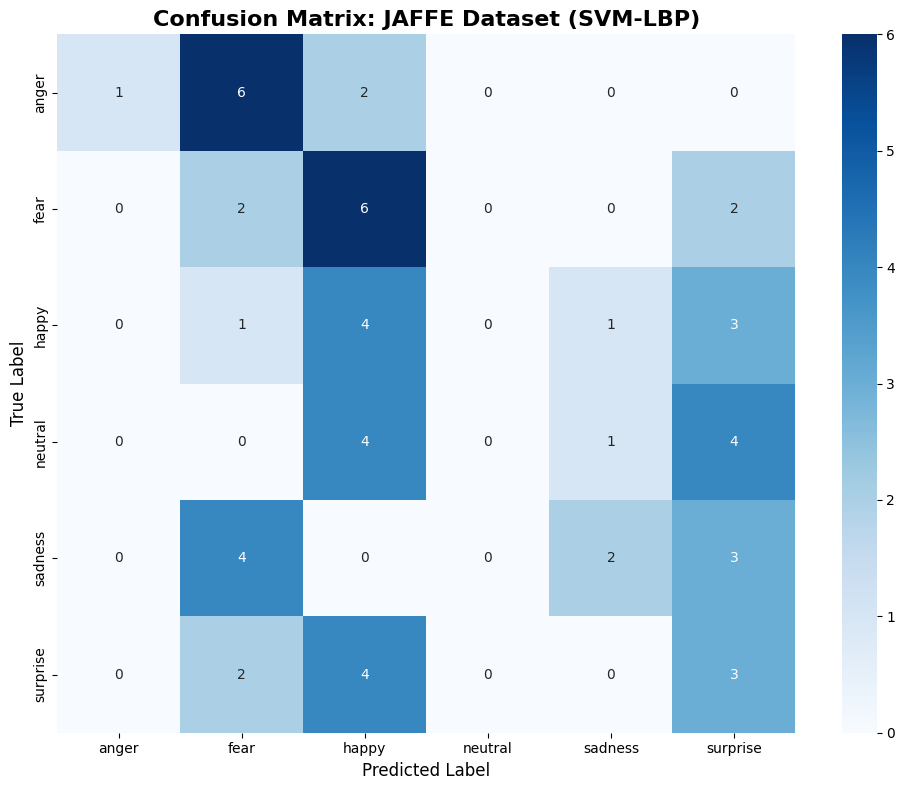

Saved: confusion_matrix_jaffe_lbp.png


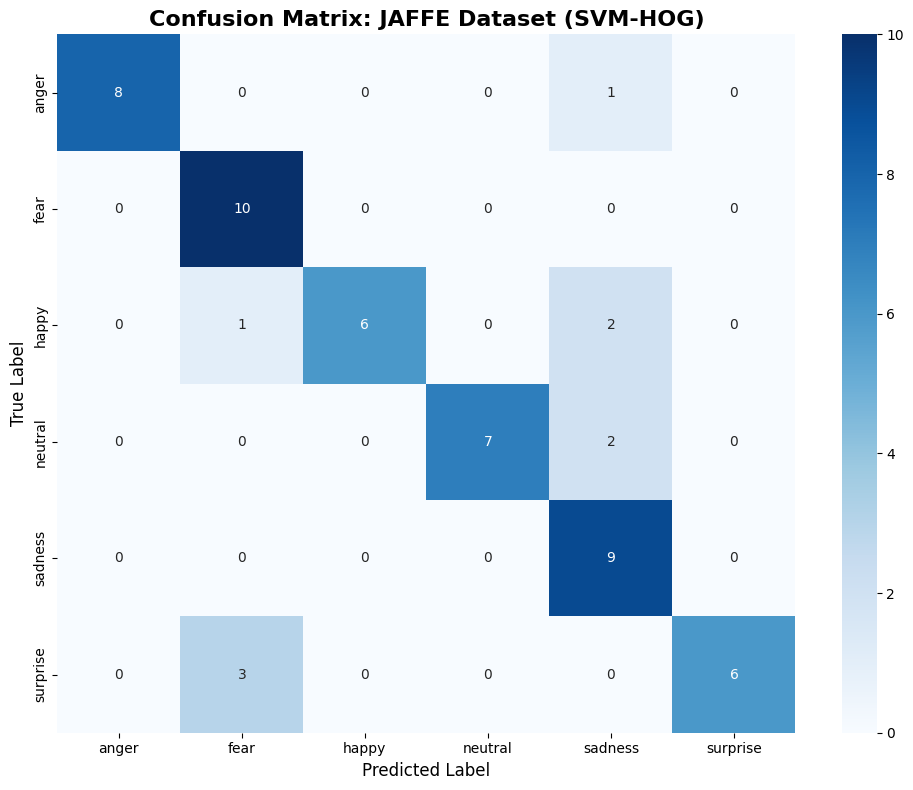

Saved: confusion_matrix_jaffe_hog.png


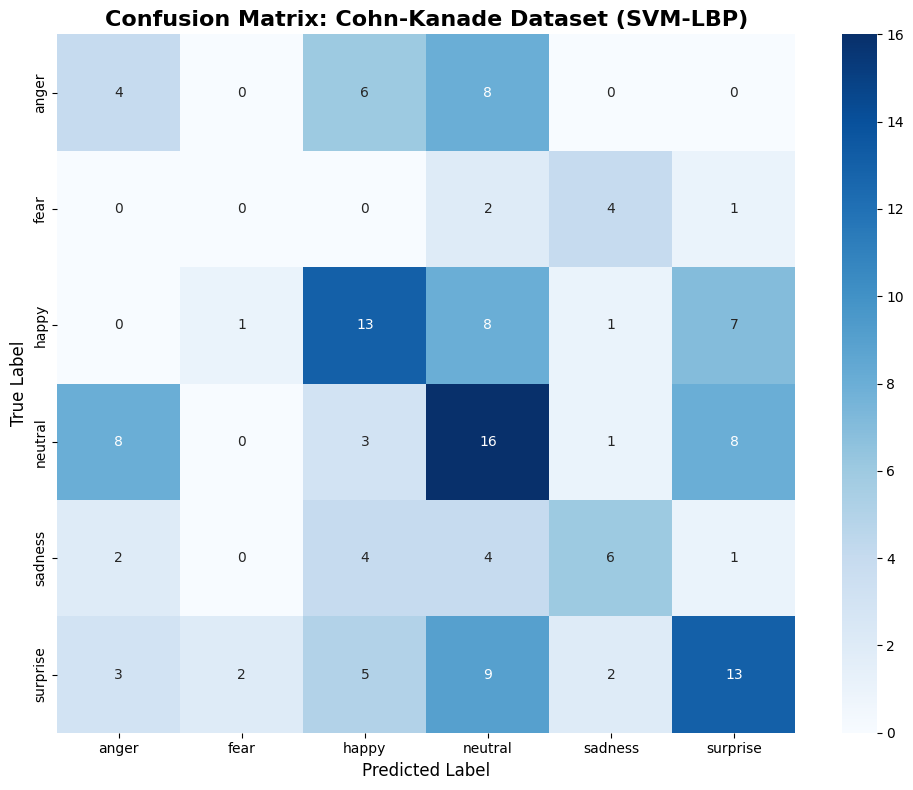

Saved: confusion_matrix_ck_lbp.png


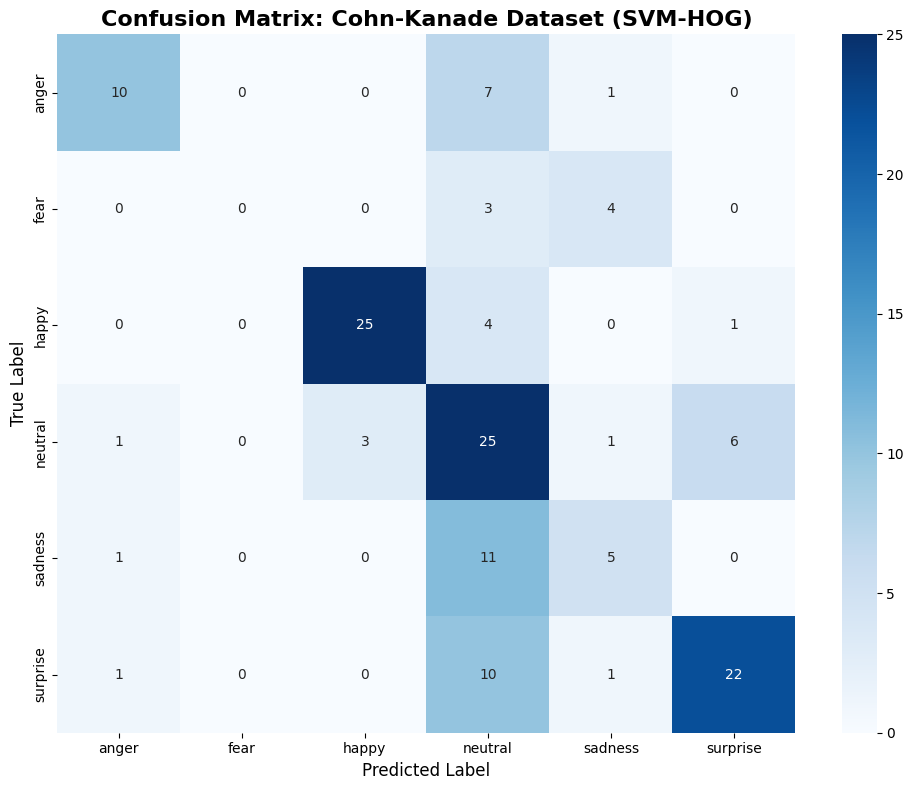

Saved: confusion_matrix_ck_hog.png

GENERATING MODEL COMPARISON PLOTS


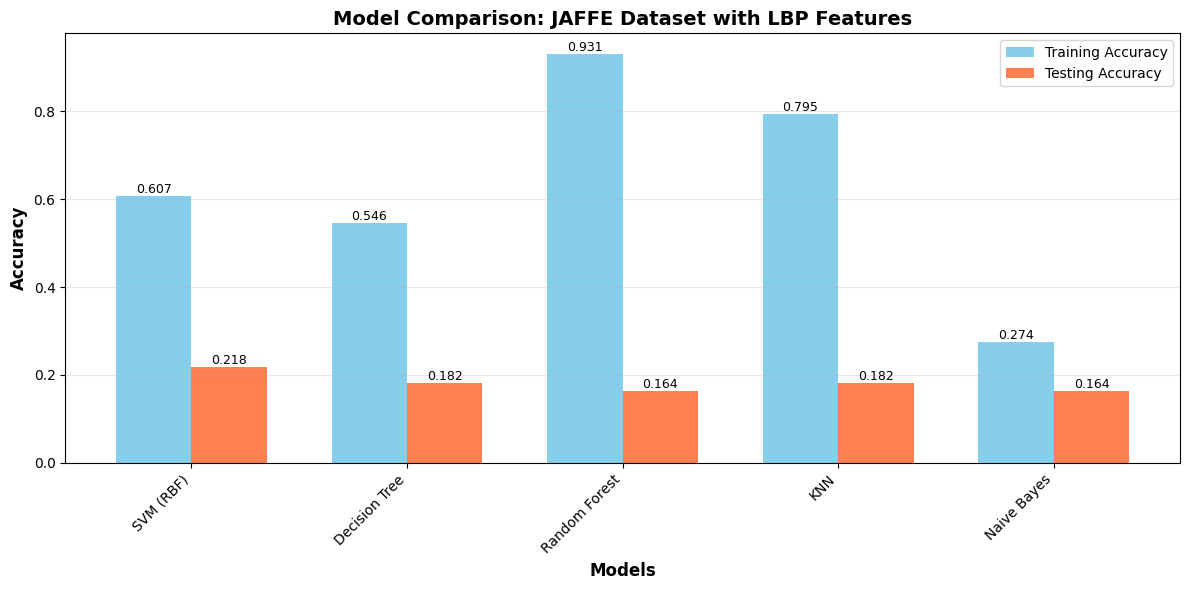

Saved: model_comparison_jaffe_lbp.png


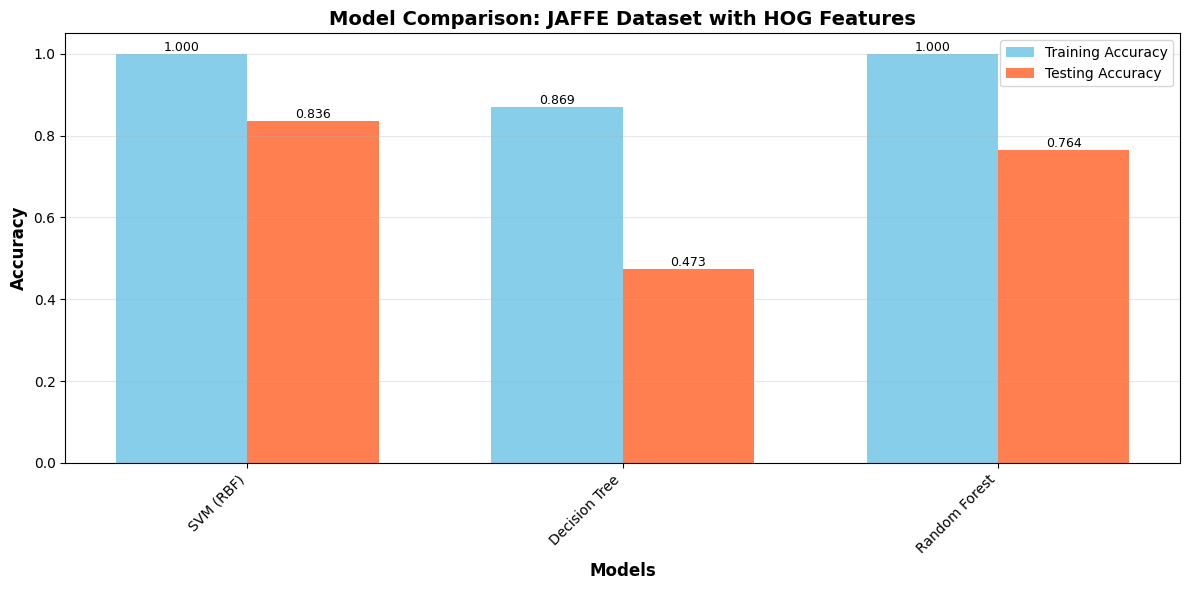

Saved: model_comparison_jaffe_hog.png


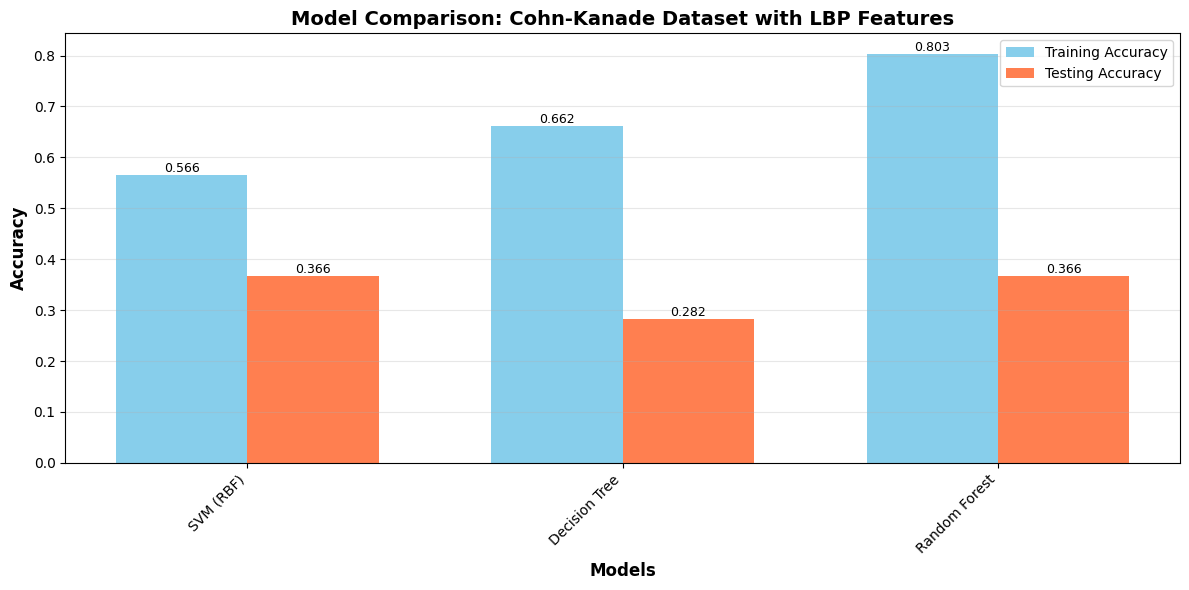

Saved: model_comparison_ck_lbp.png


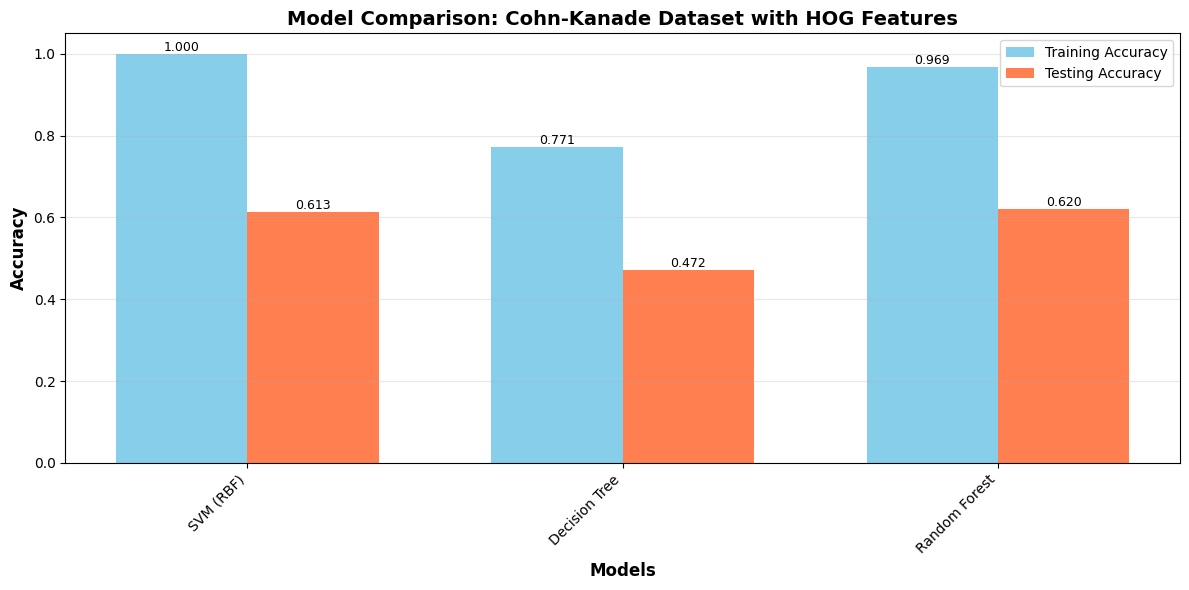

Saved: model_comparison_ck_hog.png

GENERATING SAMPLE PREDICTIONS


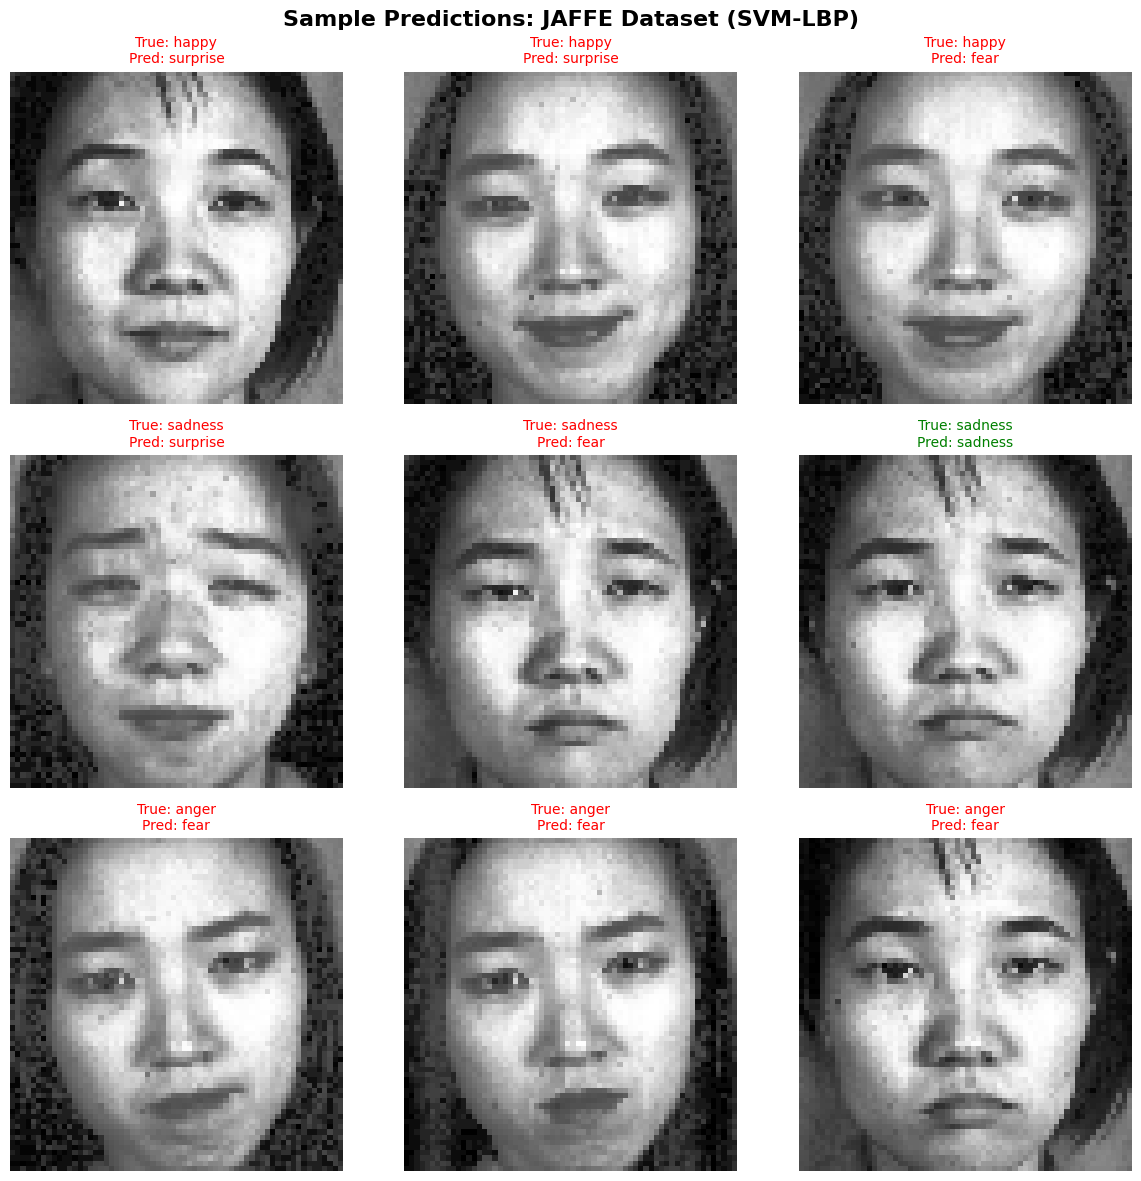

Saved: sample_predictions_jaffe_lbp.png


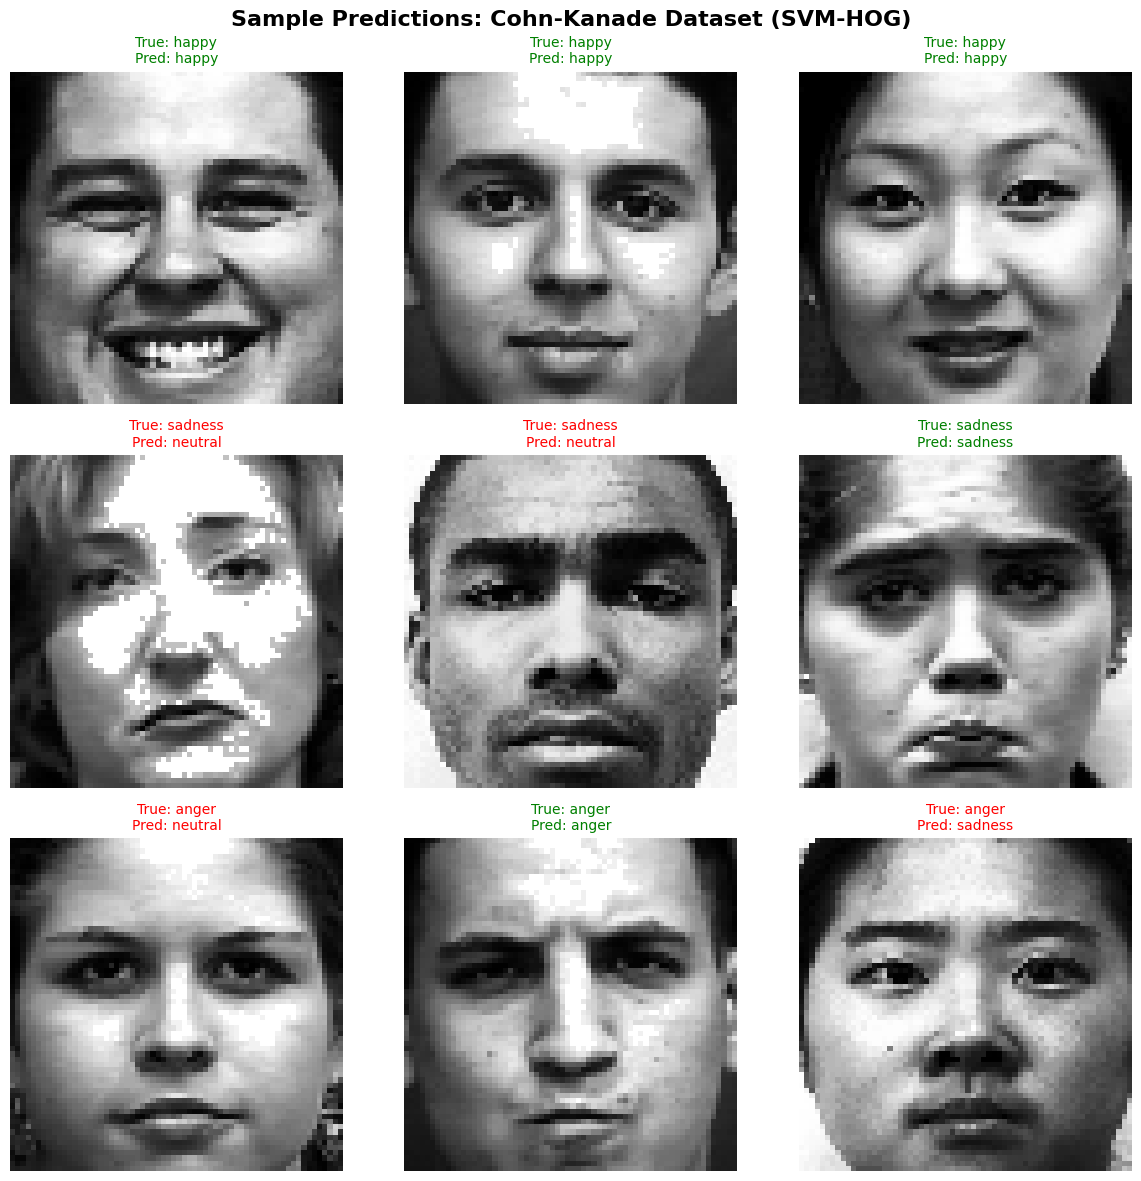

Saved: sample_predictions_cohn-kanade_hog.png

GENERATING COMPREHENSIVE RESULTS SUMMARY

FINAL RESULTS SUMMARY
        Model     Dataset Features Train Accuracy Test Accuracy Precision Recall F1-Score        CV Score
    SVM (RBF)       JAFFE      LBP         0.6069        0.2182    0.3352 0.2182   0.1982 0.2568 ± 0.0406
Decision Tree       JAFFE      LBP         0.5464        0.1818    0.1502 0.1818   0.1579 0.2344 ± 0.0462
Random Forest       JAFFE      LBP         0.9312        0.1636    0.2250 0.1636   0.1184 0.2568 ± 0.0403
          KNN       JAFFE      LBP         0.7949        0.1818    0.1753 0.1818   0.1665 0.2548 ± 0.0440
  Naive Bayes       JAFFE      LBP         0.2744        0.1636    0.0630 0.1636   0.0879 0.2280 ± 0.0343
    SVM (RBF)       JAFFE      HOG         1.0000        0.8364    0.8896 0.8364   0.8386 0.9346 ± 0.0261
Decision Tree       JAFFE      HOG         0.8691        0.4727    0.4768 0.4727   0.4593 0.4478 ± 0.0289
Random Forest       JAFFE      HOG       

In [93]:
print("\n" + "="*80)
print("TRAINING MODELS ON JAFFE DATASET WITH LBP FEATURES")
print("="*80)

jaffe_lbp_results = []

# SVM
print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', C=7, gamma='scale', random_state=42)
results, pipeline = train_and_evaluate_model(
    svm_model, jaffe_train_lbp, jaffe_train_labels_encoded,
    jaffe_test_lbp, jaffe_test_labels_encoded,
    'SVM (RBF)', 'JAFFE', 'LBP'
)
jaffe_lbp_results.append(results)
jaffe_lbp_svm_pipeline = pipeline

# Decision Tree
print("\nTraining Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    dt_model, jaffe_train_lbp, jaffe_train_labels_encoded,
    jaffe_test_lbp, jaffe_test_labels_encoded,
    'Decision Tree', 'JAFFE', 'LBP'
)
jaffe_lbp_results.append(results)

# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    rf_model, jaffe_train_lbp, jaffe_train_labels_encoded,
    jaffe_test_lbp, jaffe_test_labels_encoded,
    'Random Forest', 'JAFFE', 'LBP'
)
jaffe_lbp_results.append(results)

# KNN
print("\nTraining KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
results, pipeline = train_and_evaluate_model(
    knn_model, jaffe_train_lbp, jaffe_train_labels_encoded,
    jaffe_test_lbp, jaffe_test_labels_encoded,
    'KNN', 'JAFFE', 'LBP'
)
jaffe_lbp_results.append(results)

# Naive Bayes
print("\nTraining Naive Bayes...")
nb_model = GaussianNB()
results, pipeline = train_and_evaluate_model(
    nb_model, jaffe_train_lbp, jaffe_train_labels_encoded,
    jaffe_test_lbp, jaffe_test_labels_encoded,
    'Naive Bayes', 'JAFFE', 'LBP'
)
jaffe_lbp_results.append(results)

print("\n" + "="*80)
print("TRAINING MODELS ON JAFFE DATASET WITH HOG FEATURES")
print("="*80)

jaffe_hog_results = []

# SVM
print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', C=7, gamma='scale', random_state=42)
results, pipeline = train_and_evaluate_model(
    svm_model, jaffe_train_hog, jaffe_train_labels_encoded,
    jaffe_test_hog, jaffe_test_labels_encoded,
    'SVM (RBF)', 'JAFFE', 'HOG'
)
jaffe_hog_results.append(results)
jaffe_hog_svm_pipeline = pipeline

# Decision Tree
print("\nTraining Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    dt_model, jaffe_train_hog, jaffe_train_labels_encoded,
    jaffe_test_hog, jaffe_test_labels_encoded,
    'Decision Tree', 'JAFFE', 'HOG'
)
jaffe_hog_results.append(results)

# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    rf_model, jaffe_train_hog, jaffe_train_labels_encoded,
    jaffe_test_hog, jaffe_test_labels_encoded,
    'Random Forest', 'JAFFE', 'HOG'
)
jaffe_hog_results.append(results)

print("\n" + "="*80)
print("TRAINING MODELS ON COHN-KANADE DATASET WITH LBP FEATURES")
print("="*80)

ck_lbp_results = []

# SVM
print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', C=7, gamma='scale', random_state=42)
results, pipeline = train_and_evaluate_model(
    svm_model, ck_train_lbp, ck_train_labels_encoded,
    ck_test_lbp, ck_test_labels_encoded,
    'SVM (RBF)', 'Cohn-Kanade', 'LBP'
)
ck_lbp_results.append(results)
ck_lbp_svm_pipeline = pipeline

# Decision Tree
print("\nTraining Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    dt_model, ck_train_lbp, ck_train_labels_encoded,
    ck_test_lbp, ck_test_labels_encoded,
    'Decision Tree', 'Cohn-Kanade', 'LBP'
)
ck_lbp_results.append(results)

# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    rf_model, ck_train_lbp, ck_train_labels_encoded,
    ck_test_lbp, ck_test_labels_encoded,
    'Random Forest', 'Cohn-Kanade', 'LBP'
)
ck_lbp_results.append(results)

print("\n" + "="*80)
print("TRAINING MODELS ON COHN-KANADE DATASET WITH HOG FEATURES")
print("="*80)

ck_hog_results = []

# SVM
print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', C=7, gamma='scale', random_state=42)
results, pipeline = train_and_evaluate_model(
    svm_model, ck_train_hog, ck_train_labels_encoded,
    ck_test_hog, ck_test_labels_encoded,
    'SVM (RBF)', 'Cohn-Kanade', 'HOG'
)
ck_hog_results.append(results)
ck_hog_svm_pipeline = pipeline

# Decision Tree
print("\nTraining Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    dt_model, ck_train_hog, ck_train_labels_encoded,
    ck_test_hog, ck_test_labels_encoded,
    'Decision Tree', 'Cohn-Kanade', 'HOG'
)
ck_hog_results.append(results)

# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
results, pipeline = train_and_evaluate_model(
    rf_model, ck_train_hog, ck_train_labels_encoded,
    ck_test_hog, ck_test_labels_encoded,
    'Random Forest', 'Cohn-Kanade', 'HOG'
)
ck_hog_results.append(results)

# GENERATE ALL VISUALIZATIONS
print("\n" + "="*80)
print("GENERATING CONFUSION MATRICES")
print("="*80)

plot_confusion_matrix(
    jaffe_lbp_results[0]['Confusion Matrix'],
    'Confusion Matrix: JAFFE Dataset (SVM-LBP)',
    'confusion_matrix_jaffe_lbp.png'
)

plot_confusion_matrix(
    jaffe_hog_results[0]['Confusion Matrix'],
    'Confusion Matrix: JAFFE Dataset (SVM-HOG)',
    'confusion_matrix_jaffe_hog.png'
)

plot_confusion_matrix(
    ck_lbp_results[0]['Confusion Matrix'],
    'Confusion Matrix: Cohn-Kanade Dataset (SVM-LBP)',
    'confusion_matrix_ck_lbp.png'
)

plot_confusion_matrix(
    ck_hog_results[0]['Confusion Matrix'],
    'Confusion Matrix: Cohn-Kanade Dataset (SVM-HOG)',
    'confusion_matrix_ck_hog.png'
)

print("\n" + "="*80)
print("GENERATING MODEL COMPARISON PLOTS")
print("="*80)

plot_training_comparison(
    jaffe_lbp_results,
    'Model Comparison: JAFFE Dataset with LBP Features',
    'model_comparison_jaffe_lbp.png'
)

plot_training_comparison(
    jaffe_hog_results,
    'Model Comparison: JAFFE Dataset with HOG Features',
    'model_comparison_jaffe_hog.png'
)

plot_training_comparison(
    ck_lbp_results,
    'Model Comparison: Cohn-Kanade Dataset with LBP Features',
    'model_comparison_ck_lbp.png'
)

plot_training_comparison(
    ck_hog_results,
    'Model Comparison: Cohn-Kanade Dataset with HOG Features',
    'model_comparison_ck_hog.png'
)

print("\n" + "="*80)
print("GENERATING SAMPLE PREDICTIONS")
print("="*80)

jaffe_test_pred_labels = le.inverse_transform(jaffe_lbp_results[0]['Predictions'])

display_predictions_three_emotions(
    jaffe_test_images,
    jaffe_test_labels,
    jaffe_test_pred_labels,
    ['happy', 'sadness', 'anger'],  # Will use available emotions
    'Sample Predictions: JAFFE Dataset (SVM-LBP)',
    'sample_predictions_jaffe_lbp.png'
)

ck_test_pred_labels = le.inverse_transform(ck_hog_results[0]['Predictions'])

display_predictions_three_emotions(
    ck_test_images,
    ck_test_labels,
    ck_test_pred_labels,
    ['happy', 'sadness', 'anger'],  # Will use available emotions
    'Sample Predictions: Cohn-Kanade Dataset (SVM-HOG)',
    'sample_predictions_cohn-kanade_hog.png'
)

print("\n" + "="*80)
print("GENERATING COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

all_results = jaffe_lbp_results + jaffe_hog_results + ck_lbp_results + ck_hog_results

results_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'Dataset': r['Dataset'],
        'Features': r['Features'],
        'Train Accuracy': f"{r['Train Accuracy']:.4f}",
        'Test Accuracy': f"{r['Test Accuracy']:.4f}",
        'Precision': f"{r['Precision']:.4f}",
        'Recall': f"{r['Recall']:.4f}",
        'F1-Score': f"{r['F1-Score']:.4f}",
        'CV Score': r['CV Score']
    }
    for r in all_results
])

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv('model_results_summary.csv', index=False)
print("\nResults saved to: model_results_summary.csv")

print("\n" + "="*80)
print("ALL PROCESSING COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("1. confusion_matrix_jaffe_lbp.png")
print("2. confusion_matrix_jaffe_hog.png")
print("3. confusion_matrix_ck_lbp.png")
print("4. confusion_matrix_ck_hog.png")
print("5. model_comparison_jaffe_lbp.png")
print("6. model_comparison_jaffe_hog.png")
print("7. model_comparison_ck_lbp.png")
print("8. model_comparison_ck_hog.png")
print("9. sample_predictions_jaffe_lbp.png")
print("10. sample_predictions_cohn-kanade_hog.png")
print("11. model_results_summary.csv")

print(f"\nEmotions used in this analysis: {STANDARD_EMOTION_LABELS}")